In [1]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
import seaborn as sns
sns.set()

%matplotlib inline

In [2]:
df = pd.read_csv('../crawler/dataset.csv')
df.head(10)

,title,category,description
0,Notebook Acer Aspire 5 A515-52-56A8 Intel Core...,Notebook,Cor Prata (partes A e C). Preto (partes B e D)...
1,Notebook Acer Aspire 5 A515-52G-522Z Intel Cor...,Notebook,Aspire 5 A515-52G-522Z - Processador Intel® Co...
2,Tela P/ Notebook Acer Aspire Es1-431-P0v7 14”...,Notebook,Enviamos Sua Tela Para Notebook Acer Aspire E...
3,Notebook Lenovo B330s-15ikbr Core I5 8250u 8gb...,Notebook,Lenovo B330s acessível e confiável. Acabament...
4,"Notebook Lenovo Ideapad 330 - Tela 15.6'' HD, ...",Notebook,alt='' style='width: 500px; height: 364px;'>
5,Teclado Notebook Acer Aspire E5-571,Notebook,Imagens meramente ilustrativas
6,GigabyteAorus 15,Notebook,» Valores deste anúncio exclusivamente para ...
7,Notebook Acer Aspire A515-51-C2TQ - Tela 15.6'...,Notebook,Dimensões do produto: 381.8 x 263 x 21.6 mm
8,GigabyteAorus 15,Notebook,» Valores deste anúncio exclusivamente para ...
9,Msigs65,Notebook,» Valores deste anúncio exclusivamente para ...


Each row of the dataset contains the **title, category and description**.

In [3]:
print('Approximate number of words in the dataset(non-unique): [%d]' %
      df['description'].apply(lambda x: len(x.split(' '))).sum())

Approximate number of words in the dataset(non-unique): [1975812]


Let's check the distribution of the classes.

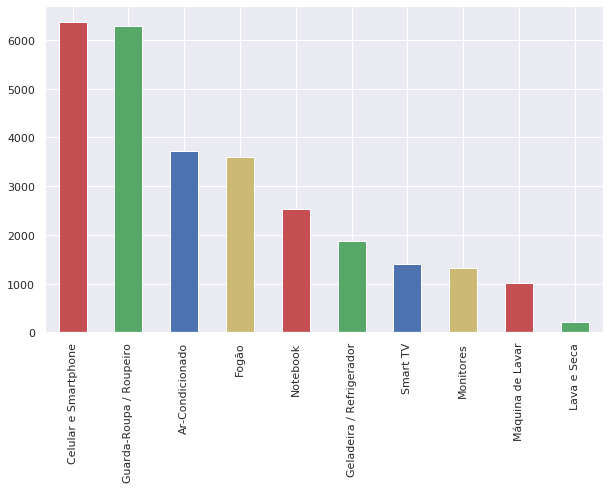

In [4]:
plt.figure(figsize=(10,6))
df.category.value_counts().plot(kind='bar', label='category', stacked=True, color=['r', 'g', 'b', 'y']);

As we can see the data is very unbalanced, so we are going to balance it using the class with minimum number of samples.

## 2. Cleaning the data

In [5]:
from nltk.stem.rslp import RSLPStemmer
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('portuguese'))
# stemmer for portugues language
stemmer = RSLPStemmer()

punctuation = """\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?[\]\^\_\`\{\|\}~"""

# Defining cleaning regexes
number_re = re.compile(r'(\d+)', re.I | re.M | re.U)
punkt_re = re.compile(r'([%s])' % punctuation, re.I | re.M | re.U)
whitespaces_re = re.compile(r'(\s)', re.I | re.M | re.U)
terms_re = re.compile(r'(garantia|fornecedor|frete|meses|desconto)', re.I | re.M | re.U)


def clean_data(text, stem=False):
    """
        text: a string

        return: modified initial string
    """
    if type(text) != str:
        raise Exception('Doc is not text data')

    # Making a copy of the original textument
    _text = text

    # Stripping
    _text = _text.strip()

    # lower case
    _text = _text.lower()

    # removing numbers
    _text = number_re.sub('', _text)
    
    # removing context terms
    _text = terms_re.sub('', _text)

    # removing long white spaces to single space
    _text = whitespaces_re.sub(' ', _text)

    # Removing stopwords and words that aren't four units long
    tokens = [
        token for token in word_tokenize(_text)
        if (token not in stop_words and len(token) > 4 and '\\' not in token)
    ]
    if stem:
        _text = ' '.join([stemmer.stem(word) for word in tokens])
    else:
        _text = ' '.join([word for word in tokens])

    return _text

In [6]:
# Merging the two text data into one so we have all the descriptive text that defines a category
df['text'] = df['title'] + ' ' + df['description']
# cleaning the new text data
df.text = df.text.apply(clean_data, stem=False)

Data example below

In [7]:
df.text

0        notebook aspire intel ªgeração memória windows...
1        notebook aspire a-g-z intel geração geforce as...
2        notebook aspire neide notebook enviamos notebo...
3        notebook lenovo bs-ikbr radeon windows preto l...
4        notebook lenovo ideapad intel intel graphics s...
                               ...                        
28325    capinha shock samsung galaxy geométrico quarkc...
28326    cb-bl especificações faster charging carrega r...
28327    película vidro iphone iphone cases todos diret...
28328    película premium silicone/gel transparente sam...
28329    carregador portátil power multilaser carregado...
Name: text, Length: 28330, dtype: object

In [8]:
print('Number of words after pre-processing: [%d]' %
      df['text'].apply(lambda x: len(x.split(' '))).sum())

Number of words after pre-processing: [980312]


# Classification Models

## Multinomial Naive Bayes

### The Algorithm
The algorithm it is very statistical based using prior and posterior probabilities of the classes in the dataset.

Using the Bayes' Theorem below as the main idea:

$$P(A | B)P(B) = P(A \cap B) = P(B \cap A) = P(B | A)P(A)$$

$$P(A | B) = \frac{P(B | A)P(A)}{P(B)}$$


Now using the theorem we can ask what is the probability of a given class given that a specific document happened.

$$p(\text{class} \mid \mathbf {\text{data}} )={\frac {p(\mathbf {\text{data}} \mid \text{class}) * p(\text{class})}{p(\mathbf {\text{data}} )}}$$

where:


* $p(class | data)$ is called the posterior.
* $p(data | class)$ is called the likelihood.
* $p(class)$ is called the prior.
* $p(data)$ is called the marginal probability.


The equation above describes the full Bayes algorithm but some probabilites are very non pratical to calculate an example of this is the $P(data)$ because if we have a never seen document in the dataset this $P(data)$ is going to be $0$, so usually we don't calculate the marginal probabilities in real word cases.






**The term Naive comes from assuming that the variables are independent of each other when they may not be**

**The Multinomial is because we are not using the standard gaussian distribution but the multinomial distribution to calculate the likelihood probabilities**

This classifier is good for cases where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice.

Under sampling results

In [9]:
from sklearn.preprocessing import label_binarize

X = df.text
y = df.category
y_og = y

categories = np.unique(y)
y = label_binarize(y, classes=categories)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

The next steps includes feature engineering. We will convert our text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized tf-idf representation (tf-idf transformer). After that, we train several classifiers.

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
# We use OneVsRestClassifier for multi-label prediction
from sklearn.multiclass import OneVsRestClassifier


def train_MNB(X_train, y_train):
    nb = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', OneVsRestClassifier(MultinomialNB())),
                   ])
    nb.fit(X_train, y_train)
    
    return nb

Now we are going to train the model and evaluate it's predicitions

In [11]:
%%time
from sklearn.metrics import classification_report

nb = train_MNB(X_train, y_train)

y_pred = nb.predict(X_test)
y_probs = nb.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))

accuracy 0.9117543240381222
                          precision    recall  f1-score   support

         Ar-Condicionado       0.99      0.97      0.98      1110
    Celular e Smartphone       0.99      0.98      0.99      1924
                   Fogão       0.99      0.98      0.99      1082
Geladeira / Refrigerador       0.97      0.83      0.89       546
 Guarda-Roupa / Roupeiro       0.99      1.00      1.00      1895
             Lava e Seca       0.33      0.01      0.03        69
               Monitores       0.98      0.58      0.73       390
        Máquina de Lavar       0.92      0.54      0.68       311
                Notebook       0.99      0.95      0.97       747
                Smart TV       0.99      0.71      0.83       425

               micro avg       0.99      0.91      0.95      8499
               macro avg       0.92      0.76      0.81      8499
            weighted avg       0.98      0.91      0.94      8499
             samples avg       0.91      0.91 

/home/leo/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [12]:
major_class = df.category.mode()[0]
print('Majority Class: %s' % major_class)

Majority Class: Celular e Smartphone


## MultinomialNB Model Evaluation

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc

# For each class
precision = dict()
recall = dict()
average_precision = dict()

for i, category in enumerate(categories):    
    precision[category], recall[category], _ = precision_recall_curve(y_test[:, i], y_probs[:, i])
    average_precision[category] = average_precision_score(y_test[:, i], y_probs[:, i])    

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_probs.ravel())
average_precision["micro"] = average_precision_score(y_test, y_probs,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.99


Plot Precision-Recall curve for each class and iso-f1 curves

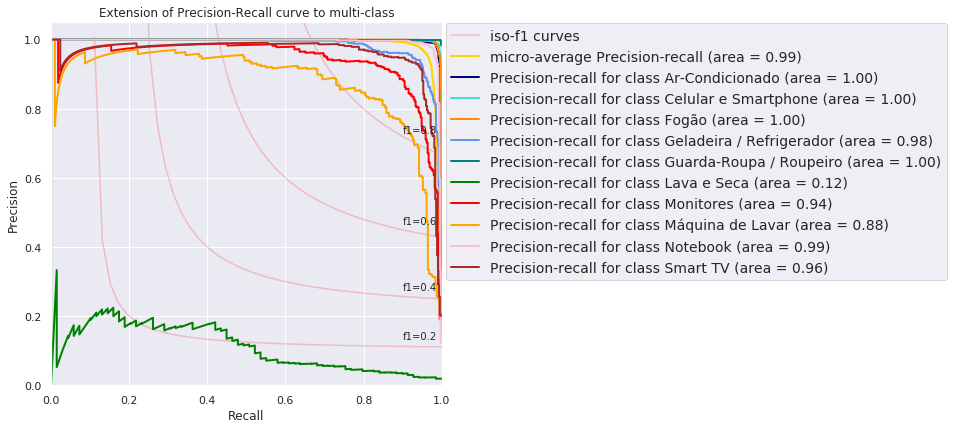

In [14]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue',
                'teal', 'green', 'red', 'orange', 'pink', 'brown'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='red', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(categories, colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(1.01, 0.29), prop=dict(size=14))


plt.show()

## Intepreting the Precision-Recall Plot

As we can see the model has 91% almos 92% accuracy during testing but we have to do extra validation because the data is very unbanlanced.

The Precision-Recall curve plot helps to evaluate if the model is able to distinguish the classes.

And for all the 9 classes except `Lava e Seca` which had an area under the curve of 0.12 the models was able to learn and predict correct values.

Further exploratory analysis and pre-processing can help the model to learn the `Lava e Seca` class.